# 使用深度卷积神经网络识别captcha验证码

[github教学连接 - 杨培文](https://github.com/ypwhs/captcha_break)

简介：  
CAPTCHA的目的是区分计算机和人类的一种程序算法，是一种区分用户是计算机还是人的计算程序

使用captcha库可以生成图片验证码。

In [1]:
# 下载Captcha库到Colab
!pip install Captcha

In [2]:
from captcha.image import ImageCaptcha
import random
import matplotlib.pyplot as plt
import numpy as np

设置验证码格式为数字加大写字母，生成一串验证码

In [3]:
import string # 导入string模块
characters = string.digits + string.ascii_uppercase
print(characters)

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


In [4]:
# 设置验证码图片的规格，包括长、宽、字数、类别数
width, height, n_len, n_class = 170, 80, 4, len(characters)
print(width, height, n_len, n_class)

170 80 4 36


In [5]:
# 创建一个验证码对象
generator = ImageCaptcha(width=width, height=height)

# 生成一组随机文字
random_str = "".join([random.choice(characters) for j in range(4)])

# 生成验证码图像
img = generator.generate_image(random_str)

In [6]:
type(img)

PIL.Image.Image

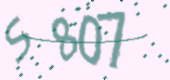

In [7]:
img

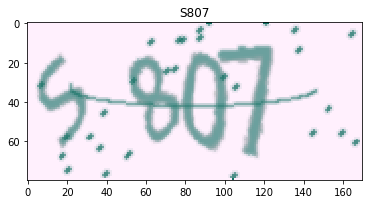

In [8]:
# 用pyplot.imshow显示验证码
plt.imshow(img); # imshow()可输入数组或者PIL图像
plt.title(random_str);

# 防止Tensorflow占用所有显存

In [9]:
import tensorflow as tf
import tensorflow.keras.backend as k

In [10]:
# # 构造config对象
# config = tf.ConfigProto() 

# # 
# config.gpu_options.allow_growth = True

# config

# sess = tf.Session(config=config)

# k.set_session(sess)

# 数据生成器

方法一：一次性生成几万张图，然后开始训练。好处是训练时显卡利用率高；  
方法二：定义一个数据生成器，利用fit_generator函数来训练， 好处是不需要生成大量数据，训练过程可以利用CPU生成数据，并且可以无限生成数据；  

数据格式：  
X的形状：(batch_size, height, width, 3)  
y的形状：四个(batch_size, n_class)，转换成numpy格式为(n_len, batch_size, n_class)

使用keras的sequence()类实现一个数据类

In [15]:
# from tensorflow.keras.utils import Sequence

In [16]:
# class CaptchaSequence(Sequence):
#     def __init__(self, characters, batch_size, steps, n_len=4, width=170, height=80):
#         """
#         定义数据所需参数
#         数据的长度为steps数
#         """
#         self.characters = characters
#         self.batch_size = batch_size
#         self.steps = steps
#         self.n_len = n_len
#         self.width = width
#         self.height = height
#         self.n_class = len(characters)
#         self.generator = ImageCaptcha(width=width, height=height)
        
#     def __len__(self):
#         return self.steps
    
#     def __getitem__(self, idx):
#         """
#         生成一批样本送去训练
#         """
#         X = np.zeros((self.batch_size, self.height, self.width, 3), dtype=np.float32)
#         y = [np.zeros((self.batch_size, self.n_class), dtype=np.uint8) for i in range(self.n_len)]
#         for i in range(self.batch_size):
#             random_str = "".join([random.choice(self.characters) for j in range(self.n_len)])
#             X[i] = np.array(self.generator.generate_image(random_str)) / 255.0
#             for j, ch in enumerate(random_str):
#                 y[j][i, :] = 0
#                 y[j][i, self.characters.find(ch)] = 1
#         return X, y

In [17]:
# 定义数据生成器，属于迭代器
def gen(batch_size = 32):
    # 是一组numpy数组
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    # y是一组标签（4个）
    y = [np.zeros((batch_size, n_class), dtype = np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height = height)
    while True:
        for i in range(batch_size):
            # 生成4字的字符串
            random_str = "".join([random.choice(characters) for j in range(4)])
            # 逐个生成验证码图像
            X[i] = generator.generate_image(random_str)
            
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0 # 似乎没用，前面已全部赋值0
                y[j][i, characters.find(ch)] = 1 # 找到对应字母的列赋值1
        yield X, y

In [18]:
# 用一个batch来检验生成器。
# 先初始化一个数据集，设置batch_size和steps为1，然后取出来第一个数据，进行可视化
def decode(y):
    # y是one-hot编码，转化为numpy数组
    y = np.argmax(np.array(y), axis = 2)[:,0]
    return "".join([characters[x] for x in y])

In [20]:
X, y = next(gen(1))

In [21]:
len(X), len(X[0]), len(X[0, 0]), len(X[0,0,0]), type(X)

(1, 80, 170, 3, numpy.ndarray)

In [22]:
len(y), len(y[0]), len(y[0][0])

(4, 1, 36)

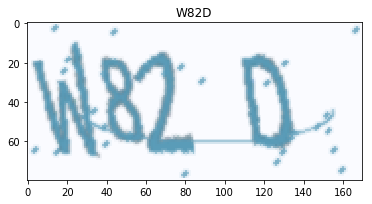

In [23]:
plt.imshow(X[0])
plt.title(decode(y));

# 构建深度卷积神经网络

In [24]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

In [25]:
# 使用keras的Input函数生成一个keras张量
input_tensor = Input(shape = (height, width, 3))

In [26]:
x = input_tensor

# 生成有4个block的卷积网络
for i in range(4):
    x = Conv2D(filters = 32 * 2 ** i, kernel_size=3, activation = "relu")(x)
    x = Conv2D(filters = 32 * 2 ** i, kernel_size=3, activation = "relu")(x)
    x = MaxPooling2D((2, 2))(x)
    
x = Flatten()(x)
x = Dropout(0.25)(x)

# 多输出模型，因此使用4个softmax分别预测4个字母的输出
x = [Dense(n_class, activation='softmax', name = 'c%d'%(i+1))(x) for i in range(4)]
model = Model(inputs = input_tensor, outputs = x)

model.compile(loss = 'categorical_crossentropy', optimizer = 'adadelta', metrics=['accuracy'])

In [28]:
# x = input_tensor

# for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
#     print(i, n_cnn)
#     for j in range(n_cnn):
#         x = Conv2D(32 * 2 ** min(i, 3), kernel_size = 3, padding = "same", kernel_initializer="he_uniform")(x)
#         x = BatchNormalization()(x)
#         x = Activation("relu")(x)
#     x = MaxPooling2D(2)(x)

# x = Flatten()(x)
# x = [Dense(n_class, activation="softmax", name='c%d'%(i+1))(x) for i in range(n_len)]
# model = Model(inputs = input_tensor, outputs = x)

In [29]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 78, 168, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 76, 166, 32)  9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 38, 83, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

## 模型可视化

In [30]:
# 使用keras自带的功能可视化模型
from tensorflow.keras.utils import plot_model

from IPython.display import Image

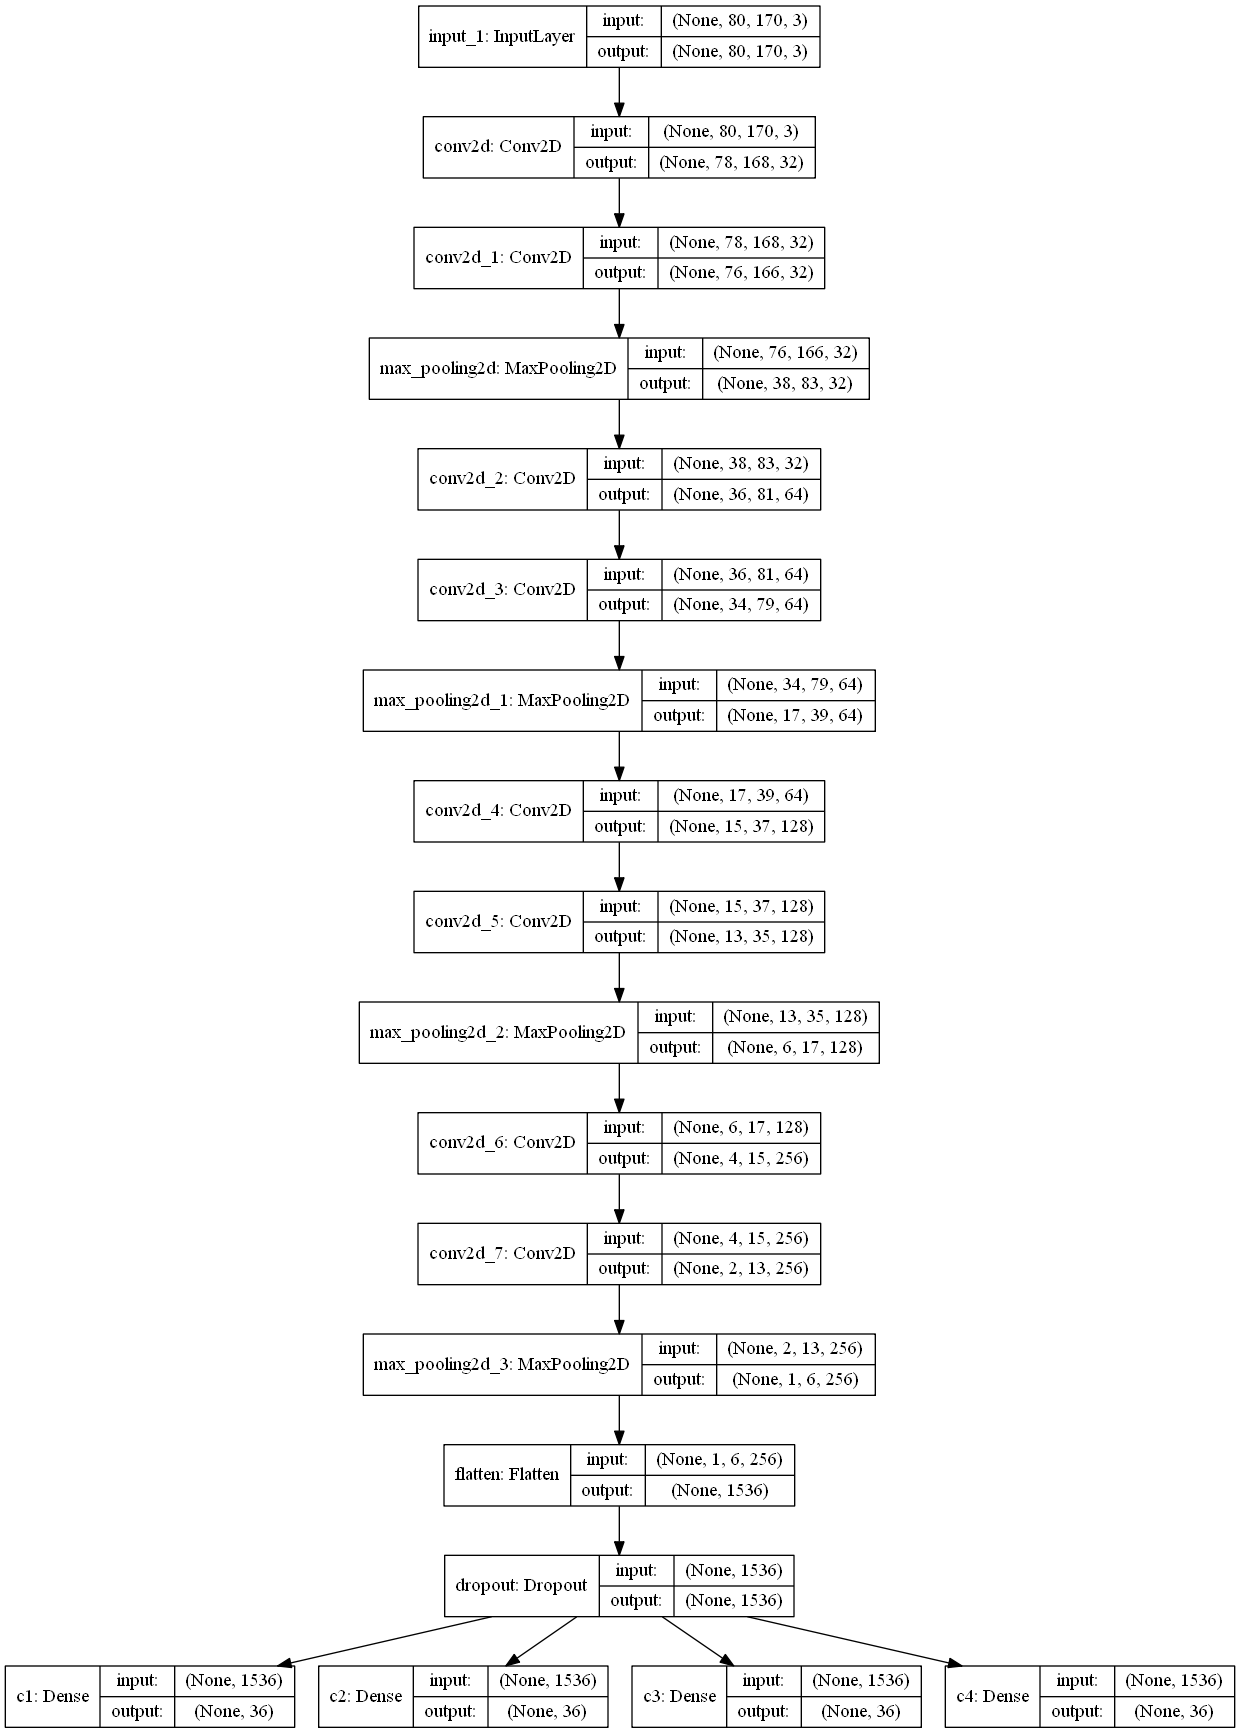

In [31]:
plot_model(model, to_file='cnn.png', show_shapes=True)
Image('cnn.png')

# 训练模型

In [32]:
# model.fit_generator(generator = gen(), steps_per_epoch = 51200, epochs = 5, workers = 2, verbose = 1, validation_data = gen(), validation_steps = 12800)

In [33]:
# 使用model.fit_generator()训练数据
from keras import callbacks
cbks = [callbacks.ModelCheckpoint("best_model.h5", save_best_only = True)]

Using TensorFlow backend.


In [34]:
history = model.fit_generator(gen(batch_size=32), \
                              steps_per_epoch=1600, epochs=5, \
                              callbacks=cbks, validation_data=gen(), \
                              validation_steps=40)

Epoch 1/5
1600/1600 [==============================] - 2521s 2s/step - loss: 14.3931 - c1_loss: 3.5997 - c2_loss: 3.5995 - c3_loss: 3.5977 - c4_loss: 3.5961 - c1_acc: 0.0273 - c2_acc: 0.0280 - c3_acc: 0.0275 - c4_acc: 0.0270 - val_loss: 14.3337 - val_c1_loss: 3.5829 - val_c2_loss: 3.5838 - val_c3_loss: 3.5840 - val_c4_loss: 3.5829 - val_c1_acc: 0.0320 - val_c2_acc: 0.0242 - val_c3_acc: 0.0273 - val_c4_acc: 0.0266
Epoch 2/5
1600/1600 [==============================] - 2668s 2s/step - loss: 14.3348 - c1_loss: 3.5837 - c2_loss: 3.5837 - c3_loss: 3.5837 - c4_loss: 3.5837 - c1_acc: 0.0280 - c2_acc: 0.0288 - c3_acc: 0.0279 - c4_acc: 0.0281 - val_loss: 14.3353 - val_c1_loss: 3.5831 - val_c2_loss: 3.5844 - val_c3_loss: 3.5841 - val_c4_loss: 3.5837 - val_c1_acc: 0.0305 - val_c2_acc: 0.0250 - val_c3_acc: 0.0328 - val_c4_acc: 0.0258
Epoch 3/5
1065/1600 [==================>...........] - ETA: 14:38 - loss: 14.3351 - c1_loss: 3.5838 - c2_loss: 3.5837 - c3_loss: 3.5839 - c4_loss: 3.5838 - c1_acc: 0.

KeyboardInterrupt: 

# 测试模型

In [ ]:
# 计算模型总体准确率
from tqdm import tqdm

In [ ]:
def evaluate(model, batch_num=100):
    batch_acc = 0
    with tqdm(gen(batch_size=128)) as pbar:
        for X, y in pbar:
            y_pred = model.predict(X)
            y_pred = np.argmax(y_pred, axis = -1).T
            y_true = np.argmax(y, axis = -1).T
            
            batch_acc += (y_true == y_pred).all(axis = -1).mean()
    return batch_acc / batch_num

evaluate(model)
        

In [ ]:
# # 识别一个验证码
# X_1, y_1 = next(gen(1))
# y_pred = model.predict(X_1)
# plt.title("real: %s\npred:%s"%(decode(y), decode(y_pred)))
# plt.imshow(X[0], cmap = 'gray')

## 计算模型总体准确率

## 模型总结

# 改进
## 循环神经网络

In [ ]:
import tensorflow.keras.backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_lambda_func(labels, y_pred, input_length, label_length)

## 模型结构

In [ ]:
input_tensor = Input((height, width, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2 if i < 3 else (2, 1))(x)

## 模型可视化

## 数据生成器

## 模型评估

## 评估回调

## 训练模型 

## 测试模型

In [ ]:
# # CSVLogger可以记录loss为CSV文件，可在训练完后绘制训练过程的loss曲线
# # ModelCheckpoint是一种Callback，在训练过程中保存最好的模型
# # EarlyStopping 是keras的Callback，在loss超过多少个epoch没有下降以后，自动终止训练，避免浪费时间
# from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint

In [ ]:
# from tensorflow.keras.optimizers import *

In [ ]:
# train_data = CaptchaSequence(characters, batch_size = 128, steps = 1000)
# valid_data = CaptchaSequence(characters, batch_size = 128, steps = 100)

In [ ]:
# callbacks = [EarlyStopping(patience=3), CSVLogger('cnn.csv'), \
#              ModelCheckpoint("cnn_best.hs", save_best_only=True)]

In [ ]:
# model.compile(optimizer=Adam(1e-3, amsgrad=True), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# start = time.time()

# model.fit_generator(train_data, epochs = 100, validation_data = valid_data, \
#                     workers = 4, use_multiprocessing=True, callbacks=callbacks)

# end = time.time()
# print(end-start)

备注：  
1. dir()函数可以返回一个函数的所有方法和属性；
2. 最后一层卷积层输出为(2,5,256)，与教程有区别(1,6,256)
3. 标签由one-hot转化为numpy数组的意义？
4. 没有采用分隔的方法
5. axis = -1 表示什么？  
6. 使用adam训练收敛速度非常慢

# 